<div class="alert alert-info">

An interactive version of this notebook is available on [Google Colab](https://colab.research.google.com/github/fpsim/fpsim/blob/main/docs/tutorials/T6_new_method_wrapped.ipynb?install=fpsim) or [Binder](https://mybinder.org/v2/gh/fpsim/fpsim/HEAD?labpath=docs%2Ftutorials%2FT6_new_method_wrapped.ipynb).

</div>

# The `add_method` intervention

This tutorial shows how to use the **`add_method`** intervention to introduce a new contraceptive method into an FPsim run at a specified year. You can use it in several ways:

- **Brand new method**: Define a full `fp.Method` and add it, copying switching behavior from an existing method.
- **Quick clone**: Clone an existing method (e.g. implants) with minimal config; useful for generic “copy” scenarios.
- **Clone + override**: Clone a method and override specific attributes (name, efficacy, duration, etc.) via `method_pars`.
- **Market splitting**: Introduce a new method that takes a fraction of another method’s market share using `split_shares`.

You always specify **when** the method becomes available (`year`) and **which existing method** to copy switching behavior from (`copy_from`). Optionally you can pass a custom `method`, `method_pars`, and/or `split_shares`.

## Setup

Import FPsim, Starsim, and set common simulation parameters. We'll use a small population and short run for quick demos.

In [1]:
import fpsim as fp
import starsim as ss
import numpy as np
import matplotlib.pyplot as plt

pars = dict(
    n_agents=2000,
    start=2000,
    stop=2020,
    location='kenya',
    verbose=0,
)
intro_year = 2010  # Year when new methods will be introduced

/Users/mine/git/fpsim/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Basic introduction (new method + market share)

The simplest use case: define a new method with `fp.Method`, introduce it at a given year, copy switching behavior from an existing method, and optionally take part of that method’s market share with `split_shares`.

In [2]:
# Define the new method
new_injectable = fp.Method(
    name='new_inj',
    label='New Injectable',
    efficacy=0.995,
    modern=True,
    dur_use=ss.lognorm_ex(mean=3, std=1.5),
)

# Intervention: introduce in intro_year, copy from injectables, take 50% of their share
intv_basic = fp.add_method(
    year=intro_year,
    method=new_injectable,
    copy_from='inj',
    split_shares=0.50,
    verbose=True,
)

sim_baseline = fp.Sim(pars=pars, label='Baseline').run()
sim_basic = fp.Sim(pars=pars, interventions=[intv_basic], label='With New Injectable').run()

print(f"Baseline mCPR: {sim_baseline.results.contraception.mcpr[-1]*100:.1f}%")
print(f"With new method mCPR: {sim_basic.results.contraception.mcpr[-1]*100:.1f}%")

Loading data from files in /Users/mine/git/fpsim/fpsim/locations/kenya/data... 
Applying calibration parameters for kenya...


Loading data from files in /Users/mine/git/fpsim/fpsim/locations/kenya/data... 
Applying calibration parameters for kenya...
Registered new method "new_inj" (idx=10), will activate in year 2010


Activating new contraceptive method "new_inj" in year 2010.0


add_method finalized: "new_inj" has 20 users (2.58% of method mix)
Baseline mCPR: 57.5%
With new method mCPR: 56.4%


## 2. Brand new method (full custom method)

Create a completely new contraceptive (e.g. hormonal ring) with custom efficacy, duration, and label. You still need `copy_from` so the model knows which method’s switching probabilities to copy.

In [3]:
hormonal_ring = fp.Method(
    name='hormonal_ring',
    label='Hormonal Ring',
    efficacy=0.991,
    modern=True,
    dur_use=ss.lognorm_ex(mean=1, std=0.5),
)

intv_brand = fp.add_method(
    year=intro_year,
    method=hormonal_ring,
    copy_from='iud',
    verbose=True,
)

sim_brand = fp.Sim(pars=pars, interventions=[intv_brand], label='With Hormonal Ring').run()
print(f"With hormonal ring mCPR: {sim_brand.results.contraception.mcpr[-1]*100:.1f}%")

Loading data from files in /Users/mine/git/fpsim/fpsim/locations/kenya/data... 
Applying calibration parameters for kenya...
Registered new method "hormonal_ring" (idx=10), will activate in year 2010


Activating new contraceptive method "hormonal_ring" in year 2010.0


add_method finalized: "hormonal_ring" has 2 users (0.26% of method mix)
With hormonal ring mCPR: 60.1%


## 3. Quick clone (copy existing method)

Add a *copy* of an existing method without defining a full `Method`: omit `method` and use `copy_from`. The new method is named `{source}_copy` unless you override it in `method_pars`. Always pass a **fresh** `dur_use` in `method_pars` to avoid sharing distribution state with the source.

In [4]:
intv_clone = fp.add_method(
    year=intro_year,
    copy_from='impl',
    method_pars={
        'dur_use': ss.lognorm_ex(mean=3, std=1),
    },
    verbose=True,
)

sim_clone = fp.Sim(pars=pars, interventions=[intv_clone], label='With Implant Clone').run()
print(f"With implant clone mCPR: {sim_clone.results.contraception.mcpr[-1]*100:.1f}%")

Loading data from files in /Users/mine/git/fpsim/fpsim/locations/kenya/data... 
Applying calibration parameters for kenya...
Registered new method "impl_copy" (idx=10), will activate in year 2010


Activating new contraceptive method "impl_copy" in year 2010.0


add_method finalized: "impl_copy" has 15 users (1.81% of method mix)
With implant clone mCPR: 56.4%


## 4. Clone + override (improved variant)

Clone an existing method and override specific attributes via `method_pars`: e.g. a new name, label, higher efficacy, or different duration. Again, provide an explicit `dur_use` when cloning methods that use callback-based duration.

In [5]:
intv_override = fp.add_method(
    year=intro_year,
    copy_from='inj',
    method_pars={
        'name': 'inj_improved',
        'label': 'Improved Injectable',
        'efficacy': 0.998,
        'dur_use': ss.lognorm_ex(mean=0.5, std=0.2),
    },
    verbose=True,
)

sim_override = fp.Sim(pars=pars, interventions=[intv_override], label='With Improved Injectable').run()
print(f"With improved injectable mCPR: {sim_override.results.contraception.mcpr[-1]*100:.1f}%")

Loading data from files in /Users/mine/git/fpsim/fpsim/locations/kenya/data... 
Applying calibration parameters for kenya...
Registered new method "inj_improved" (idx=10), will activate in year 2010


Activating new contraceptive method "inj_improved" in year 2010.0


add_method finalized: "inj_improved" has 6 users (0.65% of method mix)
With improved injectable mCPR: 55.6%


## 5. Market splitting (`split_shares`)

Model a new product that takes a fixed fraction of an existing method’s users (e.g. self-injectable DMPA-SC taking share from clinic injectables). Use `split_shares` between 0 and 1; the new method gets that fraction of users who would have chosen `copy_from`.

In [6]:
dmpasc = fp.Method(
    name='dmpasc',
    label='DMPA-SC (Self-Injectable)',
    efficacy=0.997,
    modern=True,
    dur_use=ss.lognorm_ex(mean=0.25, std=0.1),
)

intv_split = fp.add_method(
    year=intro_year,
    method=dmpasc,
    copy_from='inj',
    split_shares=0.40,
    verbose=True,
)

sim_split = fp.Sim(pars=pars, interventions=[intv_split], label='With DMPA-SC').run()

# Method-specific usage at end
cm = sim_split.connectors.contraception
fp_mod = sim_split.connectors.fp
inj_usage = fp_mod.method_mix[cm.methods['inj'].idx, -1] * 100
dmpasc_usage = fp_mod.method_mix[cm.methods['dmpasc'].idx, -1] * 100
print(f"Injectable: {inj_usage:.1f}%  |  DMPA-SC: {dmpasc_usage:.1f}%")

Loading data from files in /Users/mine/git/fpsim/fpsim/locations/kenya/data... 
Applying calibration parameters for kenya...
Registered new method "dmpasc" (idx=10), will activate in year 2010


Activating new contraceptive method "dmpasc" in year 2010.0


add_method finalized: "dmpasc" has 5 users (0.52% of method mix)
Injectable: 6.8%  |  DMPA-SC: 0.5%


## 6. Custom duration distributions

You can compare different duration-of-use distributions by cloning a method and overriding only `dur_use` (and optionally name/label) in `method_pars`. Here we add implant variants with lognormal, gamma, and exponential duration.

In [7]:
# Same baseline as above
sim_base = fp.Sim(pars=pars, label='Baseline').run()

# Variants with different duration distributions (all ~3 year mean)
configs = {
    'Lognormal': {'name': 'impl_ln', 'label': 'Implant (LN)', 'dur_use': ss.lognorm_ex(mean=3, std=1.5)},
    'Gamma':     {'name': 'impl_ga', 'label': 'Implant (Gamma)', 'dur_use': ss.gamma(a=4, scale=0.75)},
    'Exponential': {'name': 'impl_ex', 'label': 'Implant (Exp)', 'dur_use': ss.expon(scale=3)},
}
sims_dur = {'Baseline': sim_base}
for label, config in configs.items():
    intv = fp.add_method(year=intro_year, copy_from='impl', method_pars=config, verbose=False)
    sims_dur[label] = fp.Sim(pars=pars, interventions=[intv], label=label).run()

base_mcpr = sim_base.results.contraception.mcpr[-1] * 100
for k, s in sims_dur.items():
    mcpr = s.results.contraception.mcpr[-1] * 100
    diff = mcpr - base_mcpr if k != 'Baseline' else 0
    print(f"  {k:12s} mCPR: {mcpr:.1f}%  ({diff:+.1f} pp)" if k != 'Baseline' else f"  {k:12s} mCPR: {mcpr:.1f}%")

Loading data from files in /Users/mine/git/fpsim/fpsim/locations/kenya/data... 
Applying calibration parameters for kenya...


Loading data from files in /Users/mine/git/fpsim/fpsim/locations/kenya/data... 
Applying calibration parameters for kenya...


Loading data from files in /Users/mine/git/fpsim/fpsim/locations/kenya/data... 
Applying calibration parameters for kenya...


Loading data from files in /Users/mine/git/fpsim/fpsim/locations/kenya/data... 
Applying calibration parameters for kenya...


  Baseline     mCPR: 57.5%
  Lognormal    mCPR: 57.0%  (-0.5 pp)
  Gamma        mCPR: 57.8%  (+0.3 pp)
  Exponential  mCPR: 57.7%  (+0.1 pp)


## Comparing baseline vs intervention

Run a baseline and one intervention (e.g. basic new injectable), then plot mCPR over time and the new method’s share of use.

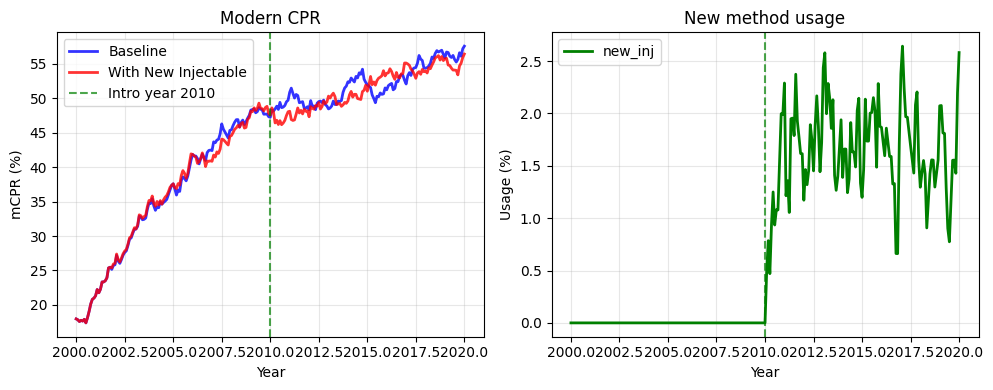

In [8]:
# Use the basic scenario (new injectable) for the comparison plot
years = np.array([float(t) for t in sim_basic.results.timevec.to_float()])

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
ax.plot(years, sim_baseline.results.contraception.mcpr * 100, 'b-', lw=2, label='Baseline', alpha=0.8)
ax.plot(years, sim_basic.results.contraception.mcpr * 100, 'r-', lw=2, label='With New Injectable', alpha=0.8)
ax.axvline(x=intro_year, color='green', linestyle='--', alpha=0.7, label=f'Intro year {intro_year}')
ax.set_xlabel('Year')
ax.set_ylabel('mCPR (%)')
ax.set_title('Modern CPR')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

ax = axes[1]
cm = sim_basic.connectors.contraception
fp_mod = sim_basic.connectors.fp
if 'new_inj' in cm.methods:
    idx = cm.methods['new_inj'].idx
    usage = fp_mod.method_mix[idx, :] * 100
    ax.plot(years, usage, 'g-', lw=2, label='new_inj')
ax.axvline(x=intro_year, color='green', linestyle='--', alpha=0.7)
ax.set_xlabel('Year')
ax.set_ylabel('Usage (%)')
ax.set_title('New method usage')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Summary

| Use case | `method` | `method_pars` | `copy_from` | `split_shares` |
|----------|----------|---------------|-------------|-----------------|
| Basic intro | ✓ custom `Method` | optional | ✓ | optional (e.g. 0.5) |
| Brand new | ✓ custom `Method` | optional | ✓ | optional |
| Quick clone | omit | `dur_use` (required) | ✓ | optional |
| Clone + override | omit | name, efficacy, dur_use, etc. | ✓ | optional |
| Market splitting | ✓ (or clone) | optional | ✓ | ✓ (0–1) |
| Custom duration | omit | name, label, `dur_use` | ✓ | optional |

**Required for all:** `year`, `copy_from`. When cloning, always pass a fresh `dur_use` in `method_pars` to avoid shared distribution state.